### Урок 9. Интеграция. Итоговый проект#

### Домашнее задание

Нужно реализовать rest api на базе flask

1. Выбрать себе датасет (который интересен или нравится больше всего), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
path = '/gdrive/MyDrive/MLBI/kurs/'

### EDA

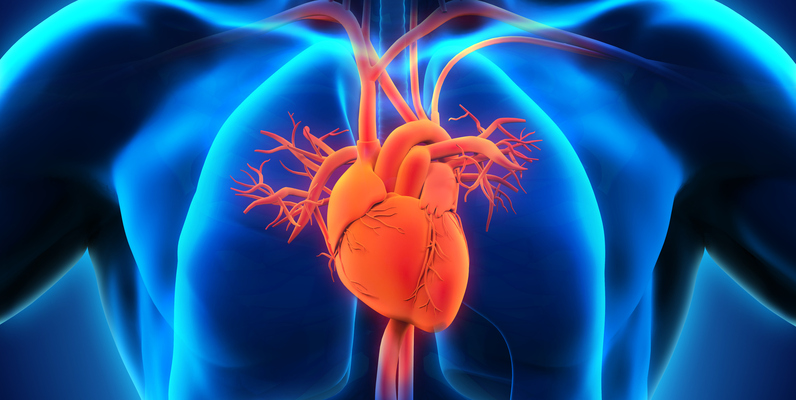

In [59]:
from IPython.display import Image
Image(path+"dataset-cover.jpg", width = 1200)

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти номер 1 во всем мире, унося, по оценкам, 17,9 миллиона жизней ежегодно, что составляет 31 % всех смертей во всем мире. Четыре из 5 смертей от ССЗ происходят в результате сердечных приступов и инсультов, и одна треть этих смертей происходит преждевременно у людей в возрасте до 70 лет. Сердечная недостаточность является распространенным событием, вызванным ССЗ, и этот набор данных содержит 11 признаков, которые можно использовать для прогнозирования возможного заболевания сердца.\
Люди с сердечно-сосудистыми заболеваниями или с высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия или уже установленное заболевание) нуждаются в раннем выявлении и лечении, в которых модель машинного обучения может оказать большую помощь.


Информация о признаках.

1. Age - Возраст: возраст пациента [лет]
2. Sex - Пол: пол пациента\
M: Мужчина\
F: Женщина
3. ChestPainType - Тип боли в груди:\
TA: Типичная стенокардия\
ATA: Атипичная стенокардия \
NAP: Боль неангинозного характера\
ASY: Бессимптомный
4. RestingBP - Артериальное давление в состоянии покоя: [мм рт.ст.]
5. Cholesterol - Холестерин: сывороточный холестерин [мм/дл]
6. FastingBS - Уровень сахара в крови натощак: уровень сахара в крови натощак \
1: если уровень сахара в крови натощак > 120 мг/дл\
0: в противном случае
7. RestingECG - Электрокардиограмма в состоянии покоя:\
Normal: Нормальный\
ST: с аномалией зубца ST-T (инверсии зубца T и/или подъем или понижение ST > 0,05 мВ)\
LVH: с вероятной или определенной гипертрофией левого желудочка по критериям Estes
8. MaxHR - Максимальная частота сердечных сокращений: [Числовое значение от 60 до 202]
9. ExerciseAngina - Стенокардия, вызванная физической нагрузкой: \
Y: да \
N: нет
10. Oldpeak - Часто является признаком ишемии миокарда, основной причиной которой является коронарная недостаточность:\
Глубина впадины сегмента ST на кардиограмме в мм
11. ST_Slope -  наклон сегмента ST (Нормальный сегмент ST имеет небольшую вогнутость вверх. Плоские, наклонные или вдавленные сегменты ST могут указывать на ишемию коронарных артерий.):\
Up: upsloping \
Flat: flat\
Down: downsloping
12. HeartDisease - Болезнь сердца (выходной класс):\
1: обнаружены болезни сердца\
0: болезни нет


In [4]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, mean_absolute_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import itertools
import dill

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.figure_factory as ff

%matplotlib inline


Посмотрим на загруженные данные

In [61]:
df = pd.read_csv(path+'heart.csv')
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Посмотрим на основные статистические данные:

In [63]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Проверим пропуски в датасете:

In [64]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Пропуски отсутствуют

Посмторим на целевую переменную:

1    508
0    410
Name: HeartDisease, dtype: int64

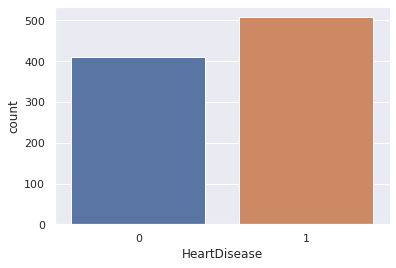

In [65]:
sns.countplot(x="HeartDisease", data=df)
df['HeartDisease'].value_counts()

Как видно из графика целевая переменная сбалансирована

Посмотрим на распределение признаков:

In [69]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])

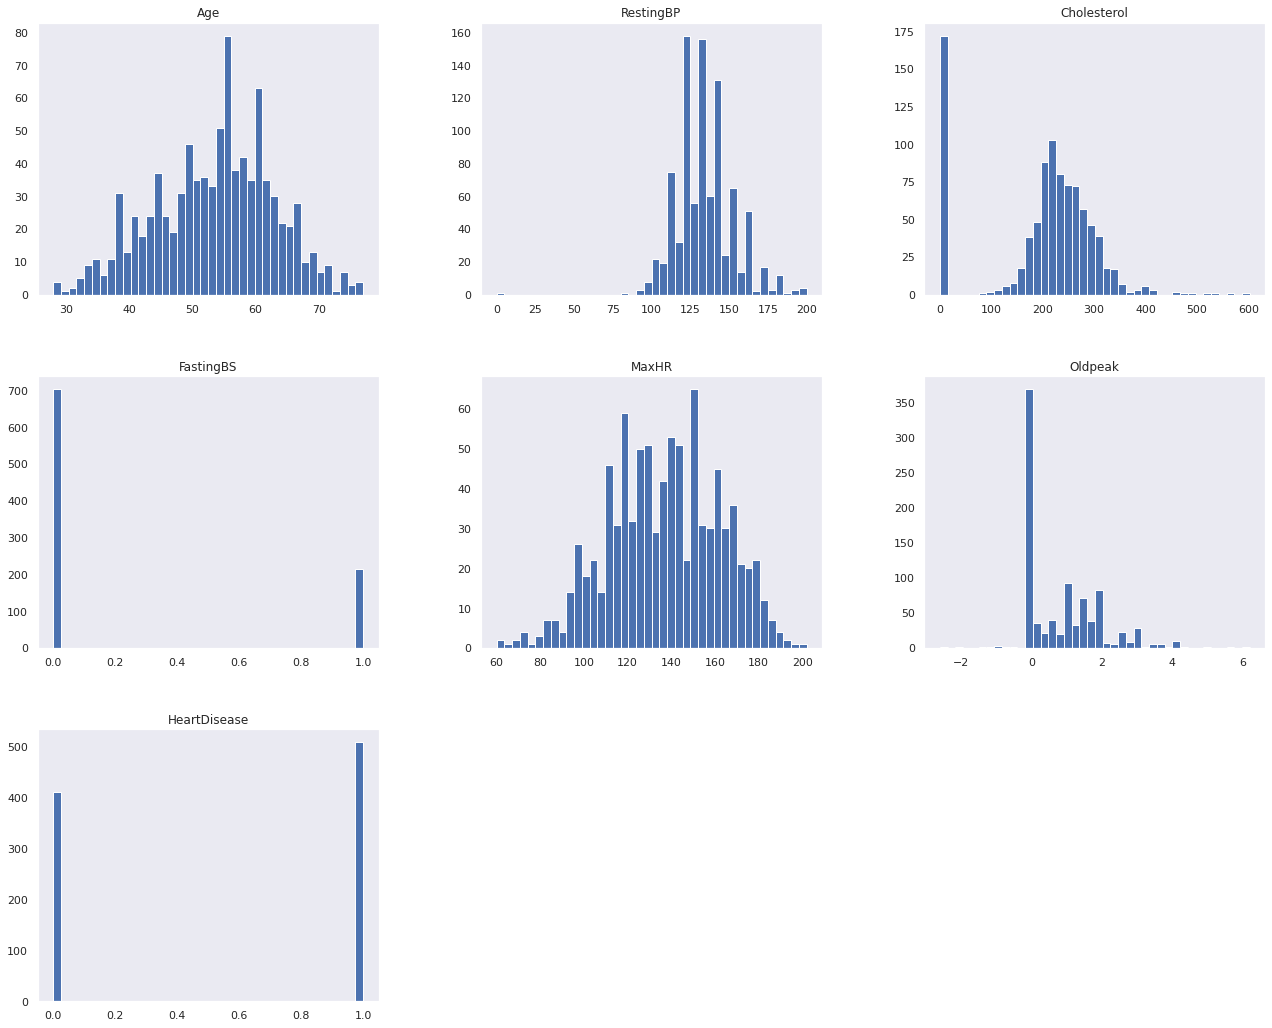

In [70]:
df_num_features.hist(figsize=(22, 18), bins=40, grid = False);

Как видно из графиков, целевая переменная "HeartDisease" имеет бинарный вид. Признак "FastingBS" также имеет бинарное распределение. Остальные признаки также имеют достаточно адекватное распределение (каких-либо выбросов или пропусков не замечено) за исключением признака "Cholesterol". С высокой долей вероятности можно предположить, что нулевых значений этот показатель иметь не может.


Посмотрим более внимательно на этт признак:

In [71]:
df['Cholesterol'].value_counts()

0      172
254     11
223     10
220     10
230      9
      ... 
355      1
354      1
353      1
349      1
603      1
Name: Cholesterol, Length: 222, dtype: int64

Исследований с нулевым значением признака "Cholesterol"  нашлось  172 экз. 

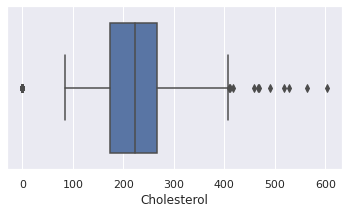

In [72]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Cholesterol'], whis=1.5)

plt.xlabel('Cholesterol')
plt.show()

Нулевые значения будем считать выбросами и заменим их на медиану.

In [73]:
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = df['Cholesterol'].median()

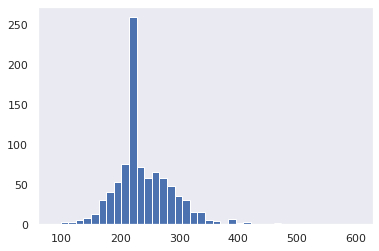

In [74]:
df['Cholesterol'].hist(bins=40, grid = False);

In [75]:
# Add histogram data
x1 = df["RestingBP"]
x2 = df["Cholesterol"]
x3 = df["MaxHR"]

# Group data together
hist_data = [x1, x2, x3]

group_labels = ['RestingBP', 'Cholesterol', 'MaxHR']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=10)
fig.show()

### FE

К полям 'Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak' применим StandardScaler\
Признаки 'Sex', 'ExerciseAngina' из категориальных переведем в бинарные\
Признаки 'ChestPainType', 'RestingECG', 'ST_Slope' преобразуем в dummies переменные\
Признак 'FastingBS' оставим без изменений

In [76]:
col_names = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [77]:
df[col_names] = features

In [78]:
binary_to_numbers = {'F': 0, 'M': 1}

df['Sex'] = df['Sex'].replace(binary_to_numbers)

In [79]:
binary_to_numbers = {'N': 0, 'Y': 1}

df['ExerciseAngina'] = df['ExerciseAngina'].replace(binary_to_numbers)

In [80]:
df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'])

In [81]:
df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,1,0.410909,0.897407,0,1.382928,0,-0.832432,0,0,1,0,0,0,1,0,0,0,1
1,-0.478484,0,1.491752,-1.122849,0,0.754157,0,0.105664,1,0,0,1,0,0,1,0,0,1,0
2,-1.751359,1,-0.129513,0.786200,0,-1.525138,0,-0.832432,0,0,1,0,0,0,0,1,0,0,1
3,-0.584556,0,0.302825,-0.492677,0,-1.132156,1,0.574711,1,1,0,0,0,0,1,0,0,1,0
4,0.051881,1,0.951331,-0.844832,0,-0.581981,0,-0.832432,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,1,-1.210356,0.434046,0,-0.188999,0,0.293283,1,0,0,0,1,0,1,0,0,1,0
914,1.536902,1,0.627078,-0.881901,1,0.164684,0,2.357094,1,1,0,0,0,0,1,0,0,1,0
915,0.370100,1,-0.129513,-2.031038,0,-0.857069,1,0.293283,1,1,0,0,0,0,1,0,0,1,0
916,0.370100,0,-0.129513,-0.084919,0,1.461525,0,-0.832432,1,0,1,0,0,1,0,0,0,1,0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    float64
 1   Sex                918 non-null    int64  
 2   RestingBP          918 non-null    float64
 3   Cholesterol        918 non-null    float64
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    float64
 6   ExerciseAngina     918 non-null    int64  
 7   Oldpeak            918 non-null    float64
 8   HeartDisease       918 non-null    int64  
 9   ChestPainType_ASY  918 non-null    uint8  
 10  ChestPainType_ATA  918 non-null    uint8  
 11  ChestPainType_NAP  918 non-null    uint8  
 12  ChestPainType_TA   918 non-null    uint8  
 13  RestingECG_LVH     918 non-null    uint8  
 14  RestingECG_Normal  918 non-null    uint8  
 15  RestingECG_ST      918 non-null    uint8  
 16  ST_Slope_Down      918 non

### FS

Построим корреляционную матрицу:

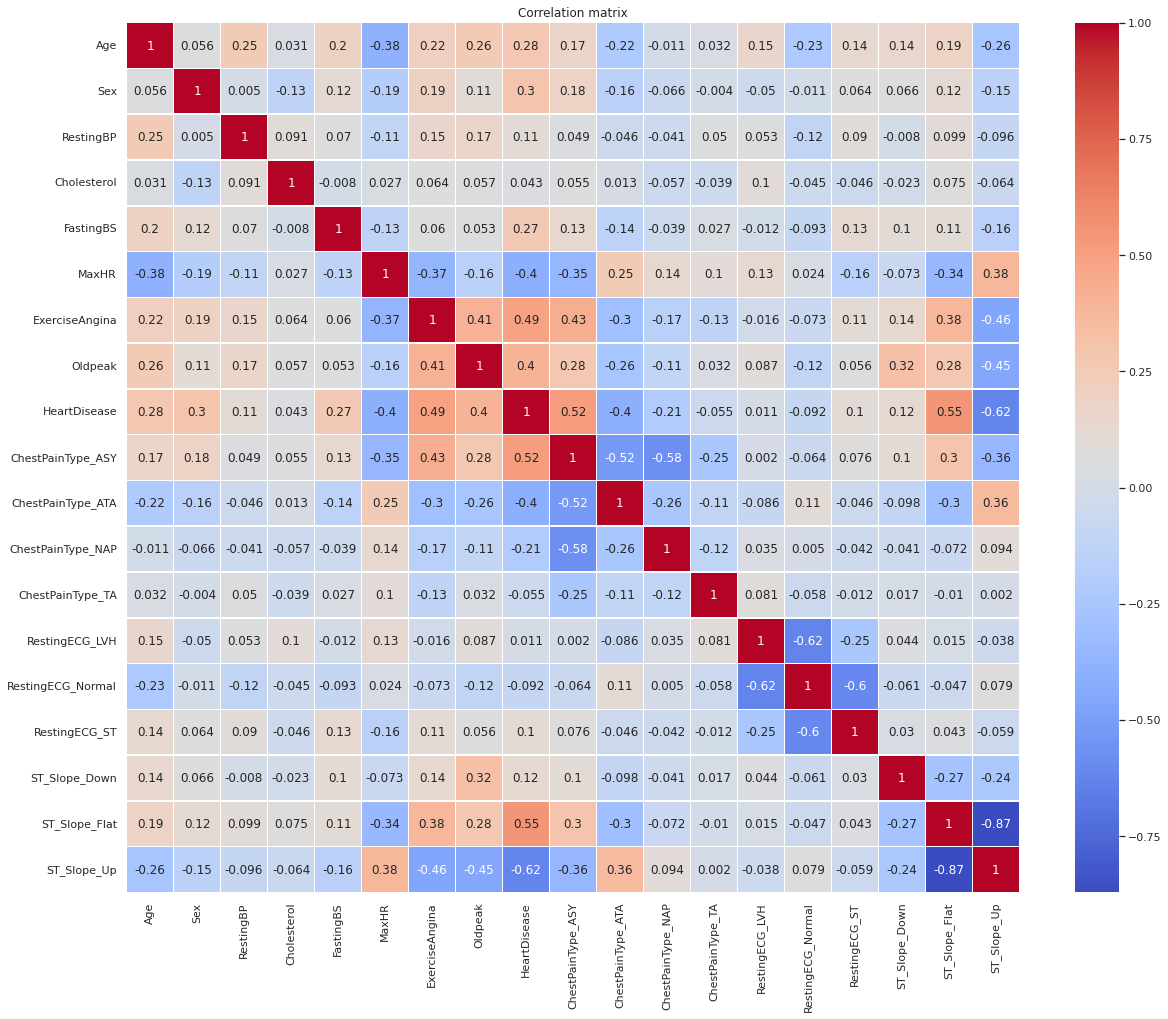

In [83]:
plt.figure(figsize = (20, 16))

sns.set(font_scale=1)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

В идеале, признаки должны иметь высокую степень корреляции с целевой переменной и не коррелировать между собой.

Признаки, с коэффициентом корреляции больше (по модулю) 0,3: 'Sex', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ST_Slope_Flat', 'ST_Slope_Up'

Так же стоит отметить, что признаки 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ASY',
       'ChestPainType_ATA' имеют достаточную корреляцию с признаками , 
       'ST_Slope_Flat' и 'ST_Slope_Up'.

Построим Pipline

Разделим данные на train/test и сохраним тестовую выборку на диск

In [5]:
df = pd.read_csv(path+'heart.csv')
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['HeartDisease'],axis=1), df['HeartDisease'], test_size=0.33, random_state=42)
#save test
X_test.to_csv(path+"X_test.csv", index=None)
y_test.to_csv(path+"y_test.csv", index=None)
#save train
X_train.to_csv(path+"X_train.csv", index=None)
y_train.to_csv(path+"y_train.csv", index=None)

Cоберем pipeline. Нам понадобится написать класс для выбора нужного поля и изменения полей

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns ]   
class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p = 2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key+str(i) for i in range(1,self.p) ]
        self.columns = B+['log']
        print(B)
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2,self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])
        Xp = np.hstack([Xp,np.log(X.values.reshape(-1,1) +1 ).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index,columns =[self.columns] )
        return B[self.columns ]     

In [8]:
X_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [9]:
categorical_columns = ['ChestPainType', 'RestingECG', 'ST_Slope' ]
continuous_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak' ]
categorical_bin_columns = [ 'Sex', 'ExerciseAngina', 'FastingBS']

Проверим работоспособность нашего pipline.

Признак пола (значения M и F трансформируются в 0 и 1:

In [91]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Sex')),
                ('ohe', OHEEncoderBin(key='Sex'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Sex_F
668,1
30,0
377,0


Признак типа боли в груди (аббревиатура трасформировалась в dummies переменные):


In [10]:
chest = Pipeline([
                ('selector', FeatureSelector(column='ChestPainType')),
                ('ohe', OHEEncoder(key='ChestPainType'))
            ])
chest.fit(X_train)
chest.transform(X_test).head(3)

,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
668,0,1,0,0
30,0,0,1,0
377,1,0,0,0


In [15]:
Age = Pipeline([
                ('selector', FeatureSelector(column='Age')),
                ('ohe', NumericPower(key='Age',p=3))
            ])
Age.fit(X_train)
print(Age.transform(X_test).head(3))

['Age1', 'Age2', 'Age3']
     Age1    Age2      Age3       log
668  63.0  3969.0  250047.0  4.158883
30   53.0  2809.0  148877.0  3.988984
377  65.0  4225.0  274625.0  4.189655


In [99]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                
                ('pow_2', NumericPower(key = cont_col, p = 3)),
                ('Scale', StandardScaler())
            ])

for kbc_col in categorical_bin_columns:
    kbc_transformer = Pipeline([
                 ('selector', NumberSelector(key=kbc_col)),
                 ('ohe_b', OHEEncoderBin(key=kbc_col))               
             ])
    

In [100]:
final_transformers

[('ChestPainType',
  Pipeline(steps=[('selector', FeatureSelector(column='ChestPainType')),
                  ('ohe', OHEEncoder(key='ChestPainType'))])),
 ('RestingECG',
  Pipeline(steps=[('selector', FeatureSelector(column='RestingECG')),
                  ('ohe', OHEEncoder(key='RestingECG'))])),
 ('ST_Slope', Pipeline(steps=[('selector', FeatureSelector(column='ST_Slope')),
                  ('ohe', OHEEncoder(key='ST_Slope'))]))]

In [101]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

VV = feature_processing.fit_transform(X_train) 
VV

array([[0, 1, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0]], dtype=uint8)

Итого, финальный pipline.

In [102]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('ChestPainType',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='ChestPainType')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='ChestPainType'))])),
                                                ('RestingECG',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='RestingECG')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='RestingECG'))])),
                                                ('ST_Slope',
                                                 Pipeline(steps

In [103]:
pipeline.steps

[('features', FeatureUnion(transformer_list=[('ChestPainType',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='ChestPainType')),
                                                  ('ohe',
                                                   OHEEncoder(key='ChestPainType'))])),
                                 ('RestingECG',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='RestingECG')),
                                                  ('ohe',
                                                   OHEEncoder(key='RestingECG'))])),
                                 ('ST_Slope',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='ST_Slope')),
                                                  ('ohe',
                                    

Сохраним наш pupeline

In [104]:
with open(path+"rf_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)